# 14. 프로젝트 : 폐렴 진단기 성능개선
## 노드 정리
1. 의료영상 분석의 특징

- 의료영상 이미지는 개인정보 보호 등의 이슈로 인해 데이터를 구하는 것이 쉽지 않다.
- 라벨링 작업 자체가 전문적 지식을 요하므로 데이터셋 구축 비용이 비싸다.
- 희귀질병을 다루는 경우 데이터를 입수하는 것 자체가 드물다.
- 음성/양성 데이터간 imbalance가 심합니다. 학습에 주의가 필요하다.
- 이미지만으로 진단이 쉽지 않아 다른 데이터와 결합해서 해석해야 할수도 있다.

2. 폐렴의 구별법     

X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰된다.

![](https://images.velog.io/images/guide333/post/e937e3f4-a559-4879-8a98-66130a6dce6e/Screenshot%20from%202021-03-02%2010-26-36.png)

정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐이다. 세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산 된 "interstitial(조직 사이에 있는)" 패턴으로 나타난다. 즉 폐렴에 걸린 사진들은 특징이 패턴을 이루고 있다.

## 순서
1. 실험환경 Set-up
2. 데이터 준비하기
3. 데이터 시각화
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화
8. 다양한 실험

### Step 1. 실험환경 Set-up
Batch size, Epoch 등을 변경할 수 있다.

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint

Duplicate key in file PosixPath('/home/aiffel-dj44/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 253 ('font.family:  sans-serif')


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 80

print(ROOT_PATH)

/home/aiffel-dj44/aiffel


### Step 2. 데이터 준비하기
캐글의 Chest X-Ray Images를 다운로드한다.
```python
$ mkdir -p ~/aiffel/chest_xray
$ cd ~/Downloads && unzip archive.zip -d ~/aiffel
```
데이터는 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함한다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있으며 전체 데이터의 크기는 총 1.2GB 정도이다. 해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X 선 영상이다.

In [3]:
# 데이터 갯수 확인
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있다. 갯수 비는 89%, 10.7%, 0.3% 이다. val 갯수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져온다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할한다.

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개이다. test_size를 수정하면 갯수는 달라질 수 있다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인한다.

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1086
Pneumonia images count in training set: 3099


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있다. CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 training을 잘 한다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정하거나 augmentation 기법을 사용할 수 있다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 괜찮다.

tf.data 인스턴스를 만든다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 헌다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# Train 데이터 셋, validation 데이터 셋 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
# 라벨 이름 확인
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


현재 이미지에는 라벨 데이터가 따로 없다. 제목에 'NORMAL', 'PNEUMONIA'라고 되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만든다.

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다. 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다. 이를 위해 decode_img 함수와 process_path 함수를 만든다.

process_path 함수에서는 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경한다. get_label을 이용해서 라벨 값을 가져온다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train 데이터 셋과 validation 데이터 셋을 만든다. num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리할 수 있다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 제대로 되었는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


위의 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다 라는 의미이다.

test 데이터 셋도 같은 방식으로 만들고 데이터 갯수를 확인한다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- ImageDataGenerator 사용    
[Data Augmentation](https://m.blog.naver.com/PostView.nhn?blogId=isu112600&logNo=221582003889&proxyReferer=https:%2F%2Fwww.google.com%2F)을 보다가 Data Augmentation을 쉽게 할 수 있다는 ImageDataGenerator 함수를 알게 되었다. ImageDataGenerator 함수를 사용하는 방법은 여러 가지가 있지만 directory를 사용하는 방법을 사용하기 했다. (flow 방법이 쉬워보였지만 자꾸 에러가 났다. 'float() argument must be a string or a number, not 'BatchDataset')

참고: <https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator>   
<https://teddylee777.github.io/tensorflow/cnn-image-classification>   
<https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/> (시각화하는 법이 나옴: 앞으로 볼 것)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = str(ROOT_PATH + '/chest_xray/train')  
validation_dir = str(ROOT_PATH + '/chest_xray/val')  
test_dir = str(ROOT_PATH + '/chest_xray/test')

In [61]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(180, 180),
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(180, 180),
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(180, 180),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다. 밑에 있는 prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환시킨다.

- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.

- repeat()를 사용하면 epoch를 진행하면서 여러번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하다. repeat()를 사용하면 자동으로 데이터를 맞춰준다.

- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다. 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉜다.

- prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

In [184]:
# def prepare_for_training(ds, shuffle_buffer_size=1000):

#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)

#     ds = ds.repeat()

#     ds = ds.batch(BATCH_SIZE)

#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인한다. train에 있는 batch 중 첫 번째 배치를 추출하고 추출된 배치를 image와 label 데이터 셋으로 나눈다. 이제 show_batch()함수를 이용해서 결과 사진을 보자.

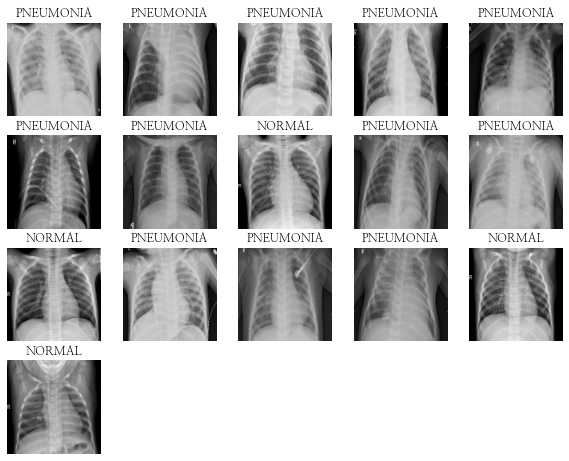

In [185]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. CNN 모델링
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있다.

BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했다. 이것은 일반적으로 잘 사용되는 형태는 아니지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 한다. 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 보았다. 또, Dropout 비율을 변경해보았다.

Convolution block을 만든다. conv_block()의 구성은 Convolution을 세 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결하고 Max Pooling을 한다.

[seperable Convolution](https://eehoeskrap.tistory.com/431)

In [84]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

Dense Block은 아래와 같다.

In [85]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [86]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        conv_block(128),
        #tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        conv_block(256),
        #tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정했다. 만약 이러한 처리를 생략한다면 어떻게 될까? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까? 
(이 부분은 하지 않았다.)

한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습 할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다. 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용된다. Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원한다. 

[딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)
>클래스 균형 클래스 균형은 소수의 클래스에 특별히 더 큰 관심이 있는 경우에 필요하다. 

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅한다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정된다.

In [87]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


### Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있다.

이미지 훈련은 GPU를 사용할 것이기 때문에 GPU를 선택한다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언한다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용한다. optimizer로 'adam'을 사용하고, 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용한다.

In [88]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

overfitting을 방지하기 위해서 early stopping 함수를 사용하였고, ModelCheckpoint를 사용하여 validation performance 가 좋은 모델을 저장하였다. (참고: [Early Stopping 의 개념과 Keras 를 통한 구현](https://3months.tistory.com/424)

In [89]:
# 모델 fit
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
BATCH_SIZE
EPOCHS = 30

with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
#         callbacks=[es, mc],
    )

Epoch 1/30
261/261 [==============================] - 60s 230ms/step - loss: 0.5334 - accuracy: 0.7596 - precision: 0.8571 - recall: 0.8156 - val_loss: 1.1360 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 61s 234ms/step - loss: 0.3309 - accuracy: 0.8482 - precision: 0.9525 - recall: 0.8340 - val_loss: 10.7780 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 59s 225ms/step - loss: 0.3075 - accuracy: 0.8657 - precision: 0.9590 - recall: 0.8579 - val_loss: 2.5154 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
261/261 [==============================] - 61s 233ms/step - loss: 0.2624 - accuracy: 0.8855 - precision: 0.9660 - recall: 0.8770 - val_loss: 6.4581 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
261/261 [==============================] - 60s 232ms/step - loss

### Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가한다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요하다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석한다.

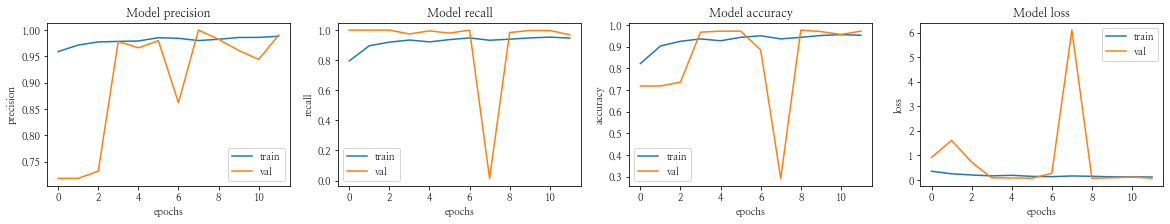

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
# 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 58ms/step - loss: 0.6509 - accuracy: 0.8093 - precision: 0.7760 - recall: 0.9769


early stopping(patience=3)과 ModelCheckpoint를 사용하였더니 노드의 결과보다 약간 높은 정확도가 나왔으나 recall의 경우는 조금 떨어졌었다. 실수로 결과가 지워져서 다시 하였더니 정확도와 recall이 떨어졌다. 

early stopping(patience=5)인 경우의 결과는 loss: 0.7881 - accuracy: 0.7724 - precision: 0.7412 - recall: 0.9769으로 노드보다 더 안 좋은 결과가 나왔다. 
(노드의 결과: loss: 0.7938 - accuracy: 0.8381 - precision: 0.7992 - recall: 0.9897) 

- epoch = 80

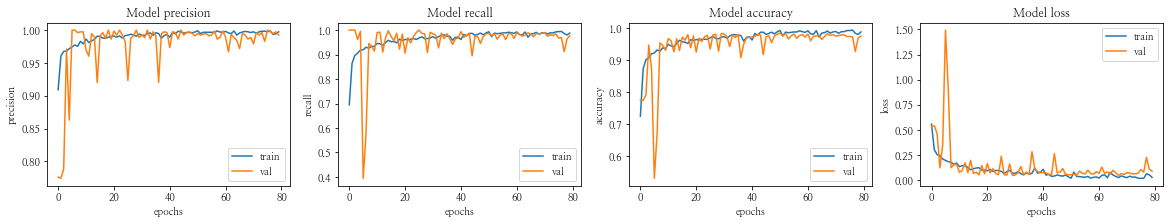

In [191]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [192]:
# 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 1.1943 - accuracy: 0.7821 - precision: 0.7433 - recall: 0.9949


이제 다양한 실험을 통하여 모델의 성능이 어떻게 변하는지 알아보고자 한다. 

## Step 8. 다양한 실험
### 1. augmentation 사용

의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문에 augmentation 도입은 신중해야 한다.

우선 좌우반전 정도의 augmentation만 도입해보자. 

In [47]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

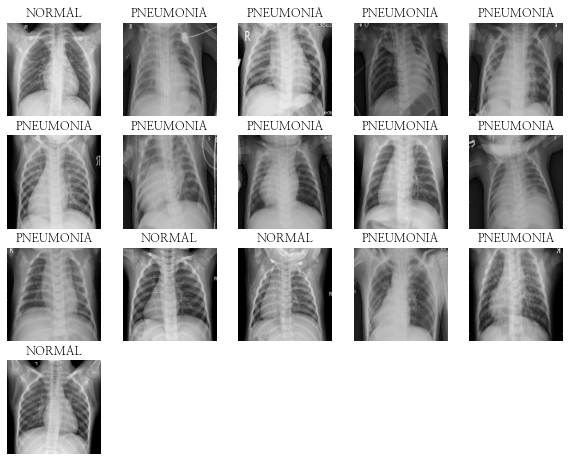

In [48]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

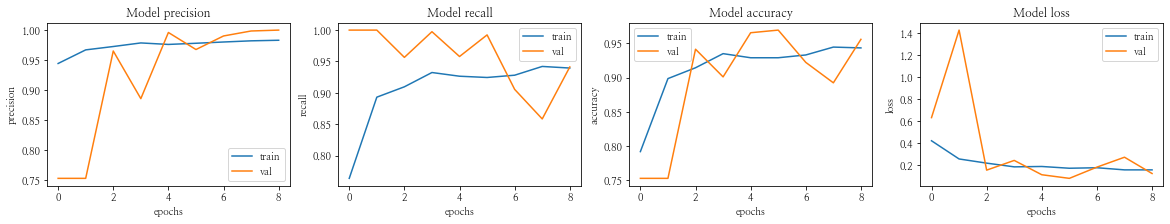

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [56]:
# 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.5367 - accuracy: 0.8173 - precision: 0.7875 - recall: 0.9692


### 2. Batch Normalization만 사용

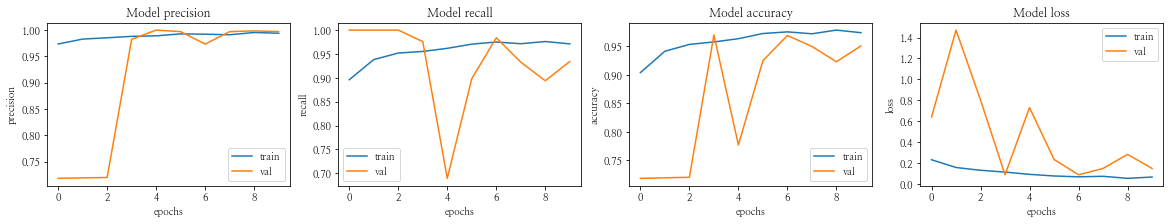

In [77]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [78]:
# 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.5909 - accuracy: 0.8413 - precision: 0.8184 - recall: 0.9590


### 3. Dropout만 사용

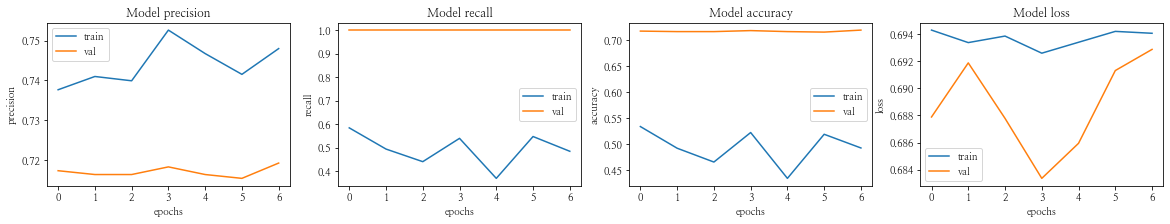

In [86]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [87]:
# 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.6930 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000


### 4. Dropout의 비율 조정
Dropout을 높게 해줄수록 성능이 좋다고 해서 0.2였던 Dropout의 비율을 0.5로 높여주었다. 

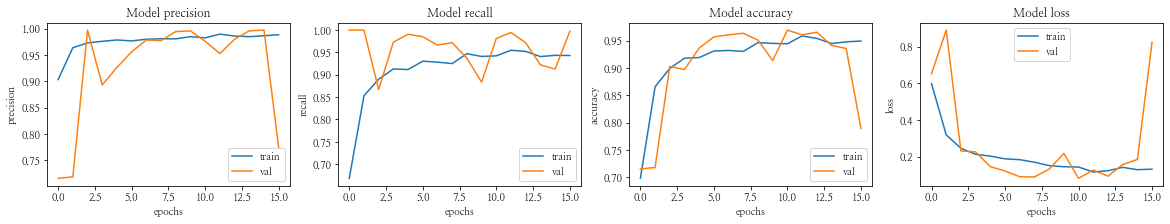

In [102]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [103]:
# 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 60ms/step - loss: 2.5252 - accuracy: 0.6378 - precision: 0.6331 - recall: 1.0000


### 5. 다양한 Data Augmentation 

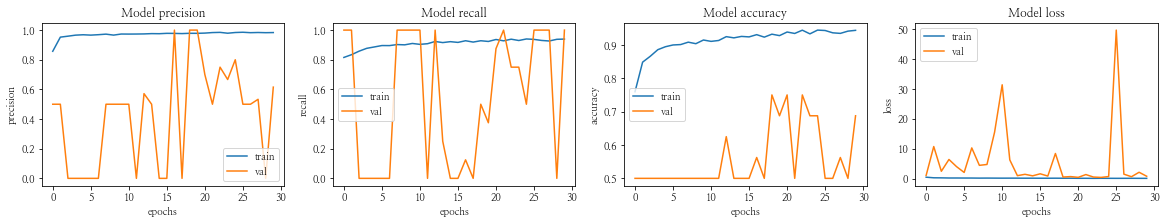

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [91]:
# 모델 평가
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 0.3580 - accuracy: 0.8846 - precision: 0.8647 - recall: 0.9667


## 정리
1. 노드의 기본 모델     
loss: 0.7938 - accuracy: 0.8381 - precision: 0.7992 - recall: 0.9897


2. epoch 조절(early stopping-patience=3 사용)    
- loss: 0.6379 - accuracy: 0.8542 - precision: 0.8243 - recall: 0.9744
- loss: 0.6509 - accuracy: 0.8093 - precision: 0.7760 - recall: 0.9769

3. epochs = 80         
- loss: 1.1943 - accuracy: 0.7821 - precision: 0.7433 - recall: 0.9949

4. epoch 조절(early stopping-patience=5 사용)    
- loss: 0.7881 - accuracy: 0.7724 - precision: 0.7412 - recall: 0.9769

5. 좌우반전의 augmentation 사용 
- loss: 0.4847 - accuracy: 0.8205 - precision: 0.9344 - recall: 0.7667
- loss: 0.5367 - accuracy: 0.8173 - precision: 0.7875 - recall: 0.9692

-> augmentation을 사용하니 오히려 정확도가 떨어졌다. 노드에서 언급했듯이 'X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문'인 것 같다. 따라서 augmentation은 앞으로 사용하지 않고 다른 방법을 사용해 보았다. 

6. Batch Normalization만 사용(Dropout 사용하지 않음)    
- loss: 0.5264 - accuracy: 0.8397 - precision: 0.8152 - recall: 0.9615
- loss: 0.5909 - accuracy: 0.8413 - precision: 0.8184 - recall: 0.9590

Dropout을 사용하지 않는 경우가 2가지 모두 사용하는 경우보다 정확도가 조금 더 높았다. 

7. Dropout만 사용(Batch Normalization은 사용하지 않음)    
- loss: 0.6930 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
recall은 높았으나 정확도가 매우 떨어졌다.

8. Dropout 의 배율 변경
- loss: 2.5252 - accuracy: 0.6378 - precision: 0.6331 - recall: 1.0000

dropout의 배율을 0.5로 바꿨더니 도리어 정확도가 매우 떨어졌다. 


9. Data augmentation을  다양하게 적용(ImageDataGenerator 사용)     

- loss: 0.3814 - accuracy: 0.8494 - precision: 0.9157 - recall: 0.8359   
지금까지 이 경우가 가장 정확도도 높았다. 그래서 모델을 바꿔 성능을 더 높여보기로 했다. 

- loss: 0.3954 - accuracy: 0.8381 - precision: 0.7992 - recall: 0.9897

- loss: 0.3580 - accuracy: 0.8846 - precision: 0.8647 - recall: 0.9667

conv_block()를 2개 더 쌓고 dropout을 사용하지 않았더니 정확도가 88.46%로 높아졌다(epoch=30).  

## 루브릭
|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|Y     |
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|Y   |
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.| Y    |

[Ablation study란 무엇인가?](https://cumulu-s.tistory.com/8)

## 후기
### 이번 프로젝트에서 어려웠던 점
- 코드를 이해하는 부분이 어려웠다. 함수가 많이 쓰여서 각 함수 내의 코드가 무슨 뜻을 의미하는지 출력해 보려고 해도 잘 되지 않았다. 
- Data Augmentation을 여러 방법을 합쳐서 사용하려고 다양한 시도를 했으나 잘 되지 않았다. 여러 시도 끝에 결국 directory를 사용하여 방법을 찾을 수 있었다. 

### 프로젝트를 진행하면서 알게된 점
- Data Augmentation을 하는 이유와 사용 방법 1가지를 알게 되었다. 
- 모델의 성능을 높이기 위해 다양한 방법을 시도해야 하며, 그 방법이 어떤 것인지 조금 알 것 같다. 

### 프로젝트를 진행하면서 아직 모호한 점
- 각 코드의 의미를 명확하게 잘 모르겠다. 
- 하이퍼파라미터를 정하거나 모델을 구성할 때 체계적으로 하는 법을 잘 모르겠다. 무작정 시도하는 방법을 사용하고 있는데, 더 좋은 방법이 있다면 알고 싶다. 

### 자기 다짐
이번 프로젝트 역시 코드를 완벽히 이해하지 못했다. 모르는 부분은 여러 블로그나 자료를 찾아가면서 해결하고 있다. 이렇게 공부하는 것이 맞는 것인지 잘 모르겠다. 완전히 내 것으로 소화하기 위해서는 어떻게 해야하는지 알고 싶다. 프로젝트를 제출하는 것만이 아닌 진짜 공부를 하고 싶다는 생각이 자꾸만 든다. 